# CARS recommender system
Implementation of the deep NN model described in the paper "Context-Aware Recommendations Based on Deep
Learning Frameworks".
https://dl.acm.org/doi/10.1145/3386243

Datasets:
- frappe


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # to split dataset
from sklearn.metrics import * # evaluation metrics
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Concatenate
from keras.optimizers import Adam
import matplotlib.pyplot as plt # for creating visualisations

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [627]:
df = pd.read_csv('frappe/frappe.csv', sep="\t")
df

,user,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,city
0,0,0,1,morning,sunday,weekend,unknown,free,sunny,United States,0
1,1,1,7,afternoon,saturday,weekend,unknown,free,cloudy,Spain,0
2,2,2,6,evening,monday,workday,unknown,free,cloudy,Spain,369
3,3,3,1,sunset,thursday,workday,unknown,free,unknown,United States,1028
4,4,4,428,night,thursday,workday,home,free,sunny,Switzerland,147
...,...,...,...,...,...,...,...,...,...,...,...
96198,110,0,5,evening,sunday,weekend,unknown,free,sunny,United States,0
96199,37,16,101,sunset,sunday,weekend,unknown,free,cloudy,Canada,128
96200,181,33,243,afternoon,sunday,weekend,unknown,free,cloudy,Israel,454
96201,451,752,1,evening,sunday,weekend,unknown,free,sunny,United States,0


In [628]:
# count number of unknown values
display(df.isin(['unknown']).sum(axis=0))

# count number of zero values (for city 0 == unknown)
display(df.isin([0]).sum(axis=0))


user             0
item             0
cnt              0
daytime          0
weekday          0
isweekend        0
homework     75670
cost             0
weather      12529
country       7025
city             0
dtype: int64

user            25
item           521
cnt              0
daytime          0
weekday          0
isweekend        0
homework         0
cost             0
weather          0
country          0
city         38052
dtype: int64

## Dataset preprocessing

In [629]:
# log transformation on the raw frequency numbers represents the application usage
df['cnt'] = df['cnt'].apply(np.log10)
f"frequency range is {df['cnt'][df['cnt'] == df['cnt'].min()].values[0]} to {df['cnt'][df['cnt'] == df['cnt'].max()].values[0]}"

# delete columns that are not needed
del df['homework']
del df['cost']
del df['city']

In [630]:
# delete rows where country and weather are unknown
df = df[df.weather != 'unknown']
df = df[df.country != 'unknown']

df = df.reset_index(drop=True)

# make user and items id start from 0
df.user = pd.factorize(df.user)[0]
df.item = pd.factorize(df.item)[0]

df

,user,item,cnt,daytime,weekday,isweekend,weather,country
0,0,0,0.000000,morning,sunday,weekend,sunny,United States
1,1,1,0.845098,afternoon,saturday,weekend,cloudy,Spain
2,2,2,0.778151,evening,monday,workday,cloudy,Spain
3,3,3,2.631444,night,thursday,workday,sunny,Switzerland
4,4,4,0.778151,sunset,saturday,weekend,sunny,Spain
...,...,...,...,...,...,...,...,...
83535,95,0,0.698970,evening,sunday,weekend,sunny,United States
83536,30,33,2.004321,sunset,sunday,weekend,cloudy,Canada
83537,155,26,2.385606,afternoon,sunday,weekend,cloudy,Israel
83538,398,671,0.000000,evening,sunday,weekend,sunny,United States


In [631]:
# change column type to category and convert categorical data to integers
context_labels = ['daytime', 'weekday', 'isweekend', 'weather', 'country']
for col in context_labels:
    df[col] = df[col].astype('category').cat.codes.values

# fill unknown values with median


In [632]:
# train and test datasets
train_x, test_x = train_test_split(df, test_size=0.2)

# train and test context features
train_context = pd.concat([train_x.pop(x) for x in context_labels], axis=1)
test_context = pd.concat([test_x.pop(x) for x in context_labels], axis=1)

# train and test labels
train_y = train_x.pop('cnt')
test_y = test_x.pop('cnt')

f"train_x: {train_x.shape}   train_y: {train_y.shape}   train_context: {train_context.shape}    test_x: {test_x.shape}   test_y: {test_y.shape}     test_context:   {test_context.shape}"    

'train_x: (66832, 2)   train_y: (66832,)   train_context: (66832, 5)    test_x: (16708, 2)   test_y: (16708,)     test_context:   (16708, 5)'

In [633]:
def min_max_norm(df):
    return (df - df.min()) / (df.max() - df.min())

train_context = min_max_norm(train_context)
test_context = min_max_norm(test_context)
train_context

,daytime,weekday,isweekend,weather,country
47228,0.166667,0.000000,0.0,0.285714,0.500000
58187,0.166667,0.500000,0.0,0.000000,0.756410
73756,0.000000,0.833333,1.0,0.000000,0.987179
23323,0.666667,0.166667,1.0,0.000000,0.243590
10960,0.500000,0.000000,1.0,1.000000,0.987179
...,...,...,...,...,...
40164,0.166667,0.833333,1.0,0.285714,0.243590
72482,0.166667,0.833333,1.0,1.000000,0.756410
26869,0.166667,0.500000,0.0,1.000000,0.987179
68334,0.000000,0.333333,0.0,1.000000,0.423077


In [634]:
# count unique user and item
n_users, n_items = len(df.user.unique()), len(df.item.unique())
n_context = len(context_labels)

# embedding vectors length
n_latent_factors_user = 8
n_latent_factors_item = 12

f'Number of users: {n_users}      Number of apps: {n_items}     Number of context features: {n_context}'

'Number of users: 861      Number of apps: 3662     Number of context features: 5'

## ECAM NCF

In [635]:
def ecam_ncf():
    # inputs
    item_input = Input(shape=[1],name='item')
    user_input = Input(shape=[1],name='user')
    context_input = Input(shape=(n_context, ), name='context')

    # Item embedding
    item_embedding_mlp = Embedding(n_items + 1, n_latent_factors_item, name='item_embedding')(item_input)
    item_vec_mlp = Flatten(name='flatten_item')(item_embedding_mlp)
    item_vec_mlp = keras.layers.Dropout(0.2)(item_vec_mlp)

    # User embedding
    user_vec_mlp = Flatten(name='flatten_user')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='user_embedding')(user_input))
    user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

    # Concat user embedding,item embeddings and context vector
    concat = Concatenate(name='user_item')([item_vec_mlp, user_vec_mlp, context_input])

    # dense layers
    dense = Dense(8, name='fully_connected_1')(concat)
    batch_1 = BatchNormalization()(dense)
    dense_2 = Dense(4, name='fully_connected_2')(batch_1)
    batch_2 = BatchNormalization()(dense_2)
    dense_3 = Dense(2, name='fully_connected_3')(batch_2)

    # Output
    pred_mlp = Dense(1, activation='relu',name='Activation')(dense_3)

    # make and build the model
    return keras.Model([user_input, item_input, context_input], pred_mlp)

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 12)        43956       item[0][0]                       
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         6896        user[0][0]                       
___________________________________________________________________________________________

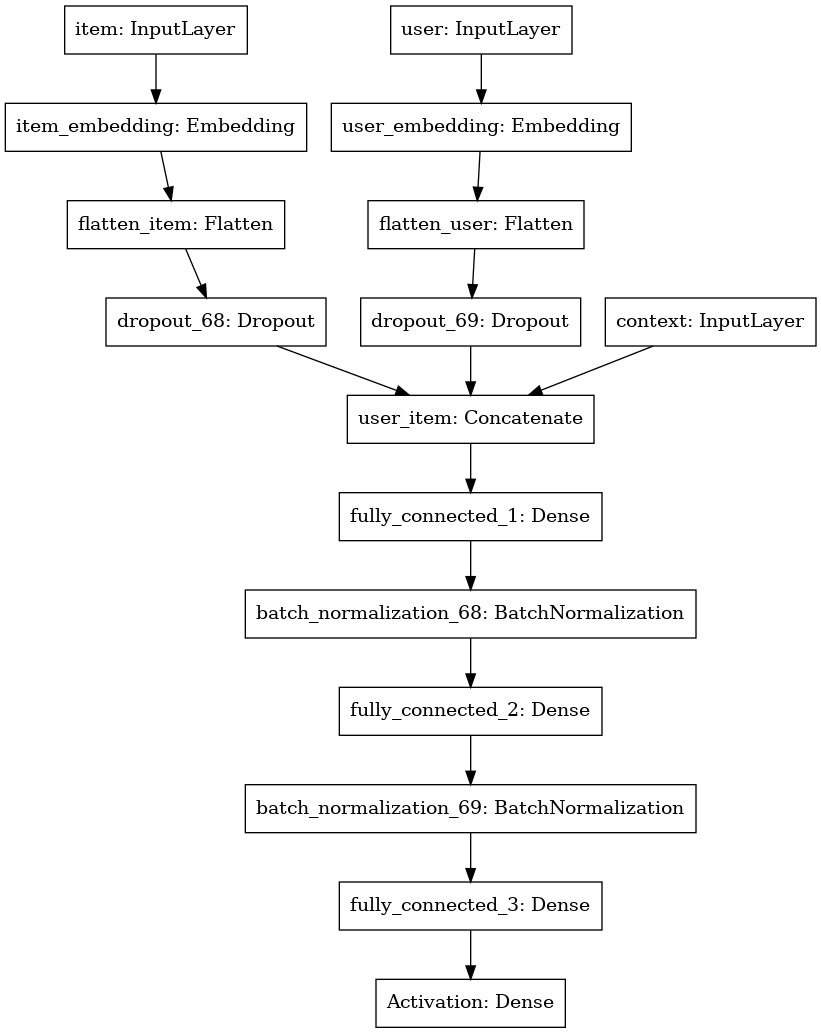

In [636]:
ecam_ncf = ecam_ncf()
opt = keras.optimizers.Adam(lr = 0.005)
ecam_ncf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

ecam_ncf.summary()
tf.keras.utils.plot_model(ecam_ncf)

In [637]:
history = ecam_ncf.fit([train_x.user, train_x.item, train_context], train_y, epochs=15, batch_size=128, verbose=1)

Epoch 1/15
523/523 [==============================] - 2s 3ms/step - loss: 0.5838 - mae: 0.5838 - mse: 0.5892
Epoch 2/15
523/523 [==============================] - 2s 3ms/step - loss: 0.5333 - mae: 0.5333 - mse: 0.4997
Epoch 3/15
523/523 [==============================] - 2s 3ms/step - loss: 0.5254 - mae: 0.5254 - mse: 0.4903
Epoch 4/15
523/523 [==============================] - 2s 4ms/step - loss: 0.5201 - mae: 0.5201 - mse: 0.4819
Epoch 5/15
523/523 [==============================] - 2s 3ms/step - loss: 0.5172 - mae: 0.5172 - mse: 0.4806
Epoch 6/15
523/523 [==============================] - 2s 4ms/step - loss: 0.5154 - mae: 0.5154 - mse: 0.4776
Epoch 7/15
523/523 [==============================] - 4s 8ms/step - loss: 0.5136 - mae: 0.5136 - mse: 0.4770
Epoch 8/15
523/523 [==============================] - 3s 5ms/step - loss: 0.5129 - mae: 0.5129 - mse: 0.4751
Epoch 9/15
523/523 [==============================] - 4s 8ms/step - loss: 0.5119 - mae: 0.5119 - mse: 0.4736
Epoch 10/15
523/523

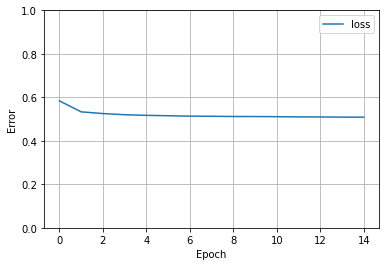

In [638]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [639]:
pred_y = ecam_ncf.predict([test_x.user, test_x.item, test_context]).flatten()

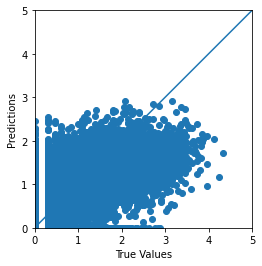

In [640]:
a = plt.axes(aspect='equal')
plt.scatter(test_y, pred_y)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [641]:
rmse = mean_squared_error(test_y, pred_y, squared = False)
mse = mean_squared_error(test_y, pred_y, squared = True)
mae = mean_absolute_error(test_y, pred_y)
f'RMSE = {rmse}    MAE = {mae}    MSE = {mse}'

'RMSE = 0.6928330434839377    MAE = 0.5253070553373819    MSE = 0.48001762614321597'